- Overall thoughts and initial explorations into the bond premium indicator
- Some indications of clear shortcomings and potential ways to improve this indicator

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

#### Initialization

In [2]:
WEEKDAYS_IN_YEAR = 261
DAYS_IN_MONTH = 20

dl = DataLib("SignalData")
BondReturnIdx = dl.pull("BondRetIdx/LocalFX")
fxvsusd = dl.pull("fxVsUSD")
equities = dl.pull("EquityPrices")
m1 = dl.pull("M1/inUSD")
m2 = dl.pull("M2/inUSD")
m3 = dl.pull("M3/inUSD")
curr_acct_nom = dl.pull("CurrAcctNom/inUSD")
curr_acct_gdp = dl.pull("CurrAcctPctGDP")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
fxNominal = dl.pull("fxTrdWts/Nominal")
fxReal = dl.pull("fxTrdWts/Real")
core_cpi = dl.pull("CoreCPI/SA")
gdp_real = dl.pull("GDP/Real")

## Indicator - Bond Premium + Curve Height

In [4]:
def rolling_z_score(data, window, min_periods):
    rolling = data.rolling(window, min_periods)
    mean = rolling.mean()
    std = rolling.std()
    return (data - mean)/std

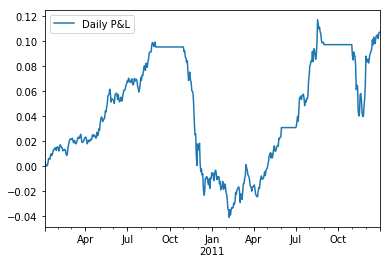

In [411]:
start_date = '1985-01-01'
end_date = '2010-01-01'
trade_date = '2010-01-02'
unwind_date = '2012-01-01'
trade_range = pd.date_range(trade_date, unwind_date, freq='B')
daily_ret = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily P&L"])
prior_weights = pd.Series()
long_returns = BondReturnIdx.pct_change(1)

bond_premium = LongRates - ShortRates
bond_premium = bond_premium.multiply(LongRates.ge(0))
curve_height = (LongRates + ShortRates) * 0.5
max_curve_height = curve_height.max(axis = 1)

for date in pd.date_range(trade_date, unwind_date, freq='B').date:
    bond_premium_training = bond_premium.loc[start_date:end_date]
    curve_height_training = curve_height.loc[end_date]
    curve_height_training = curve_height_training.multiply(curve_height_training.ge(0))
    
    #standardizing data across time 
    normalized_bond_premium = rolling_z_score(bond_premium_training, 12*2,12*2)
    date_normalized_premium = normalized_bond_premium.loc[end_date]
    above_norm = date_normalized_premium.gt(0)
    current_normalized_premium = date_normalized_premium.multiply(above_norm)
    
    #cross-country comparison - weighting by curve height
    curr_max_curve_height = max_curve_height.loc[end_date]
    w_curve_height = curve_height_training.mul(1/curr_max_curve_height, axis = 0)
    long_positions = current_normalized_premium * w_curve_height
    #weights_total = long_positions.sum()
#     if weights_total != 0:
#         long_positions = long_positions/weights_total
    one_day_long_return = long_returns.loc[date]
    if long_positions.sum() != 0:
        min_val = long_positions.min()
        max_val = long_positions.max()
        buy_amounts = long_positions.apply(lambda x: (x - min_val) / (max_val - min_val))
        daily_ret.loc[date] = (buy_amounts.dot(one_day_long_return))/ buy_amounts.sum()
    else:
        daily_ret.loc[date] = 0
    
    end_date = date
    
#     if daily_pl.loc[date].values  < -1:
#         print(long_positions)
#     if above_norm.sum() == 1:
#         print(date_normalized_premium)
#         print(one_day_long_return)

daily_ret.cumsum().plot()
plt.show()


In [401]:
daily_ret.loc['2014-08-11':'2016-01-01']

,Daily P&L
2014-08-11,-0.000549034
2014-08-12,-0.00178488
2014-08-13,0.0025385
2014-08-14,0.00222527
2014-08-15,0.00466011
2014-08-18,-0.00352063
2014-08-19,-0.00165601
2014-08-20,-0.00181559
2014-08-21,0.00194829
2014-08-22,0.000348681


#### Investigating failure cases 
- 2015-05-12
- 2015-06-04
- 2016-11-10

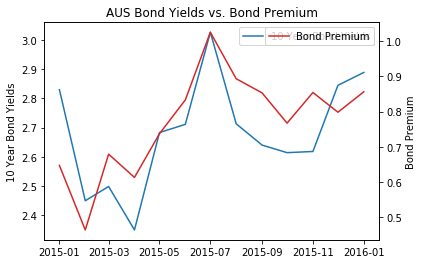

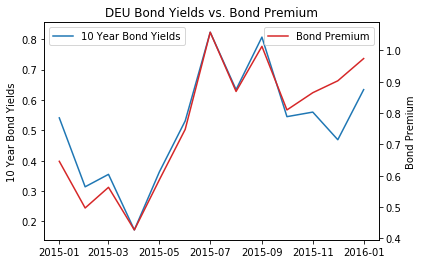

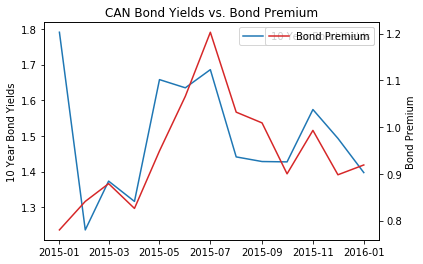

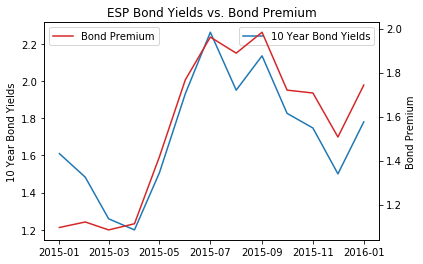

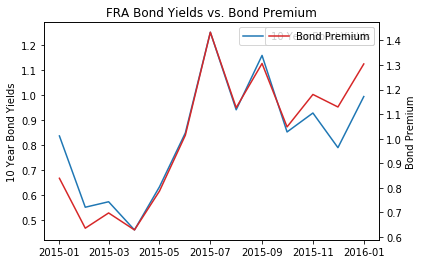

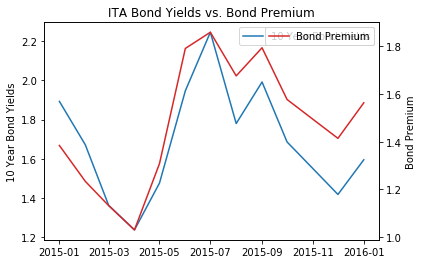

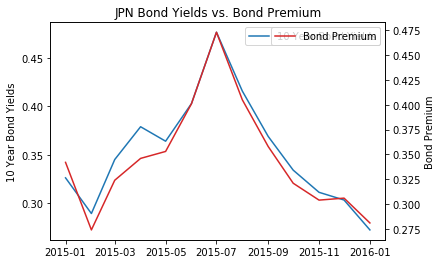

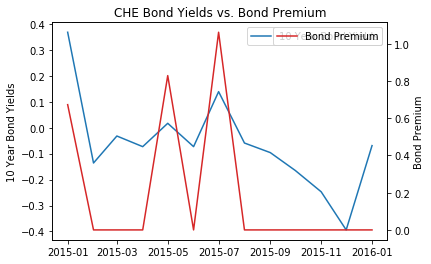

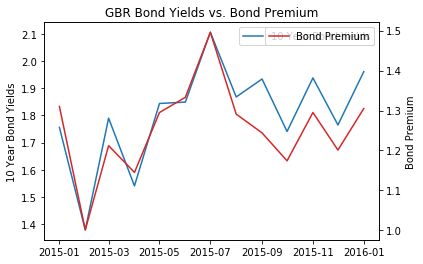

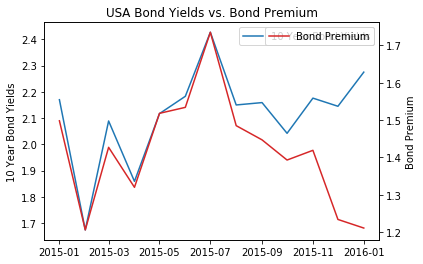

In [426]:
start_date = '2015-01-01'
end_date = '2016-01-01'
for country in bond_premium.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Bond Premium'
    ax2.plot(bond_premium[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Yields vs. Bond Premium")
    plt.show()

**Later Takeaways**: the 2009 rally in bond yields helps explain why the indicator was at odds with normalizing over short and long time frames. There's a tradeoff in both scenarios. Normalizing over an extended period of time may cause later peaks in bond premiums to be magnified. Whereas normalizing over a really short period of time may not place as much emphasis on rising bond premiums (which are not as notably high during an environment of steadily rising bond premiums). Perhaps a more effective approach would be to take a weighted moving average, which could balance out getting historical/longer-term context, while also placing an emphasis on recent events to put into perspective whether these movements are significant shifts from the "norm".

**Takeaways**:
- In the cases of failure (primarily in Australia), it's often the case that the model suggests the correct position, but earlier than the yields move as predicted. Therefore, while the model may suffer a temporary loss, a profit is often realized in the days to follow. <span style="color:green">(Future Note: this observation was actually a result of Australia having historically low bond premiums over the course of the prior 10 years. So, normalized bond premiums tended to trigger the indicator before the yield moved in accordance. In a way, it made the indicator slightly lead bond yields and increase the magnitude of normalized bond premiums.)</span>. Since the bond premium data is reported on a monthly basis and the yields may respond at some intermediary point during the month, it's likely this model is not adept at reacting to intra-month changes in bond returns.
- But, it may be possible to introduce a slight lag, between when bond premiums are raised and the trade is executed.
- Interestingly, all points of failure produce an allocation with only 1 long position. I will further investigate whether this pattern typically results in poor returns.
    - 368 cases of only 1 long position. 435 cases of > 1 long position. 240 cases of 0 long positions.
    - Of the 368 cases, 166 of them led to losses.
    - Of the 435 cases, only 92 of them led to losses.
    - And many of these cases of only 1 long position are long on Australia.

**Post-Modification Takeaways**:
- What I had initially thought was an issue of lag appeared to actually be the period of time over which I was standardizing the bond premium data. Initially, I was normalizing the bond premium data over the course of 10 years of country-specific data. But, upon further observation, these values tended to be largely negative after being normalized. This is why I was seeing a large problem of 100% long positions on 1 country (usually Australia). 
- Furthermore, the term-structure premium indicator appears to be largely effective on more of a short-term basis. As bond premiums rise, the market is likely to react rather quickly and bring down bond yields. So in order to capture these short-term changes in bond premiums, it is more indicative to normalize based on the last 6 months of bond premium data. 
- In addition to an increase in total P&L, I also saw improvements in diversification of positions. 
    - 235 cases of 1 long position now. 567 cases of > 1 long position. 241 cases of 0 long positions
    - I believe this is a normal result, since I wouldn't expect the term structure indicator to apply to every country at all points in time.
- Empirically compared curve-based weighting vs. magnitude-based weighting for positions: curve-based weighting marginally outperformed. In cases where the magnitude-based weighting performed better, it appeared to be due to more diversified views overall (more equitable weighting across all countries). So, in cases where both strategies did not perform well across all countries, the losses through magnitude-based weighting were not concentrated in any one country (such as Australia) as they were in curve-based weighting. But in times when the indicator is accurate, the curve-based weighting does help capture more positive returns. Since this indicator is being combined with other indicators for the final signal, I will opt for curve-based weighting - the other indicators will help fill in the shortcomings/limitations of this indicator and mitigate some of the larger incurred losses.
- Also from a logical perspective, when deciding between long positions in a number of countries, it makes sense to place a stronger position on countries with a larger curve height. As investors should have a higher demand for 10-year bonds in such countries (as explained in the Prospectus), these countries should also experience a greater decline in bond yields.
    
**Regarding Remaining Failure Cases**:
- Upon a deeper dive into the post-modification failure cases, I believe that the indicator reacted appropriately based on the given data. When a long position was placed, bond yields fell accordingly. Therefore, since bond yields are reported on a monthly basis, this indicator can't change its positions based on movements during the middle of the month. So, losses due to intra-month changes in returns, are to be expected.
- **Potential refinement/solution**: adjusting the indicator based on bond return data (reported daily) to proxy intra-month changes/gaps in the bond premium data

**Next Steps**:
- This indicator does not produce any views on short positions. In particular, I would like to target cases where the bond premium is negative. In combination with inflection points in GDP, this indicator could be valuable in understanding when a yield curve may uninvert. 

#### Capturing Short Term Trends in Bond Premium

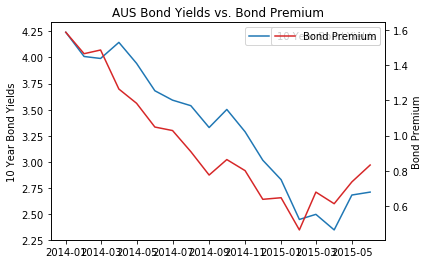

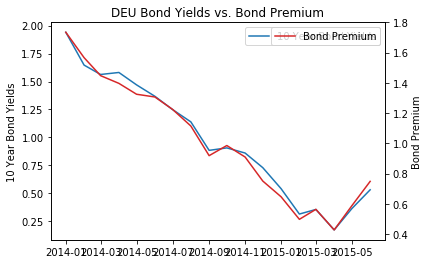

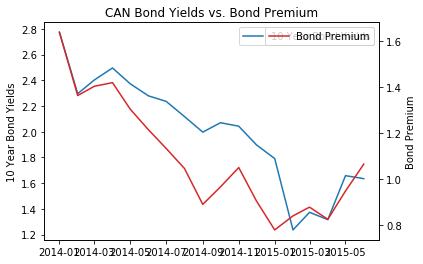

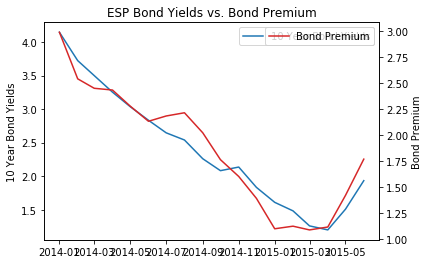

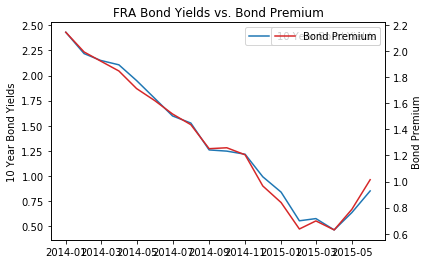

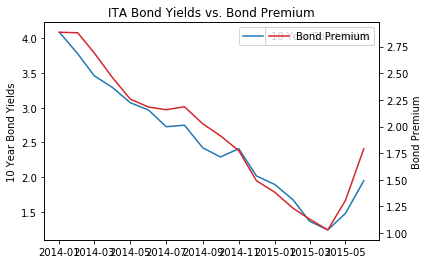

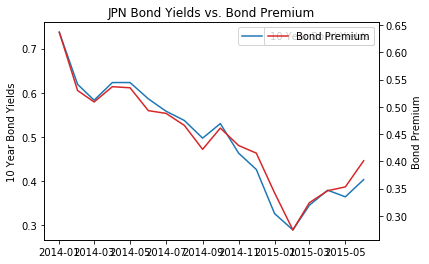

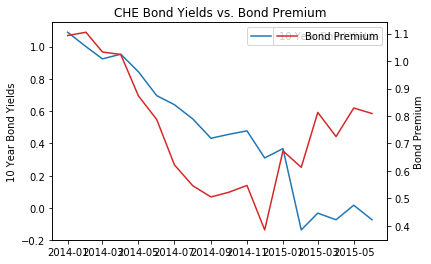

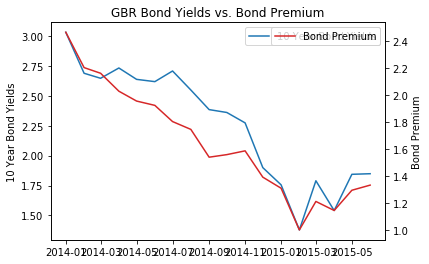

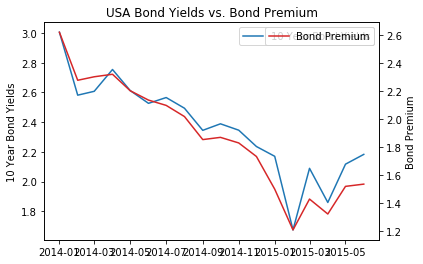

In [303]:
#2015-01 CHE is the only long position - we see a drop in bond yields
start_date = '2014-01-01'
end_date = '2015-06-01'
bond_premium = LongRates - ShortRates
for country in bond_premium.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Bond Premium'
    #ax2.plot(rolling_z_score(bond_premium, 6,6)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.plot(bond_premium[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Yields vs. Bond Premium")
    plt.show()

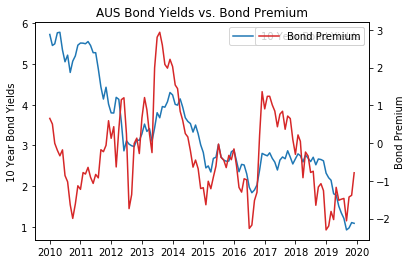

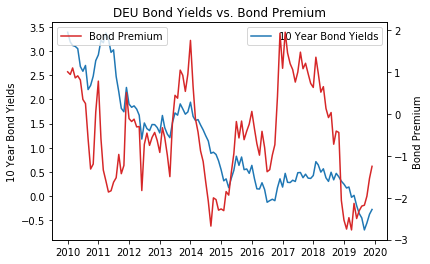

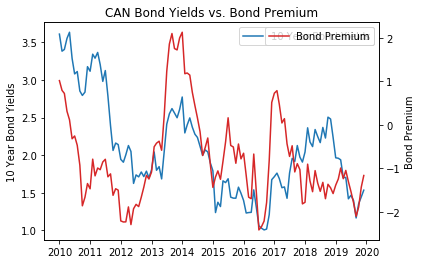

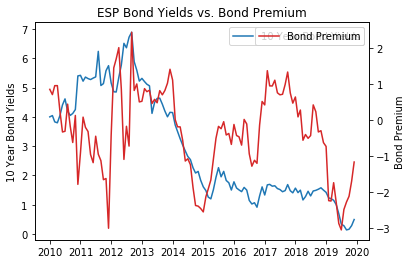

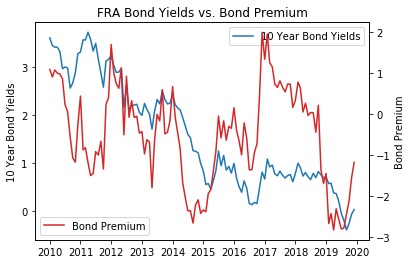

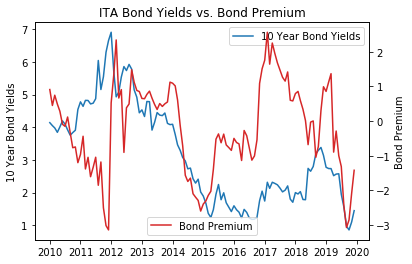

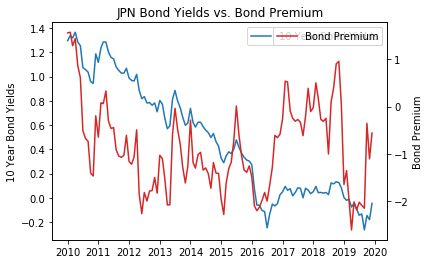

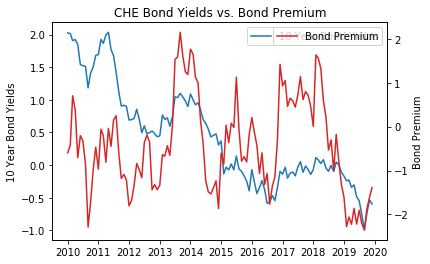

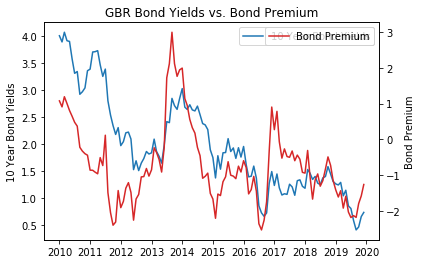

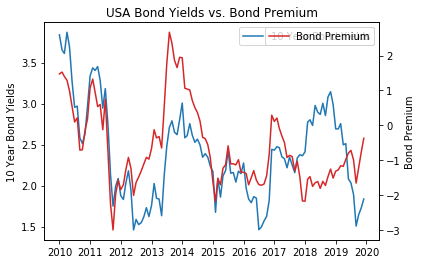

In [384]:
#larger overview: how to capture views from longer-term increases in bond premiums
#there's an interesting cyclical pattern here to point out
start_date = '2010-01-01'
end_date = '2019-12-31'
bond_premium = LongRates - ShortRates
for country in bond_premium.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Bond Premium'
    ax2.plot(rolling_z_score(bond_premium, 12*2,12*2)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    #ax2.plot(bond_premium[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Yields vs. Bond Premium")
    plt.show()

#### Capturing longer trends

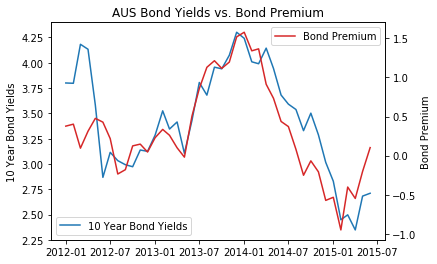

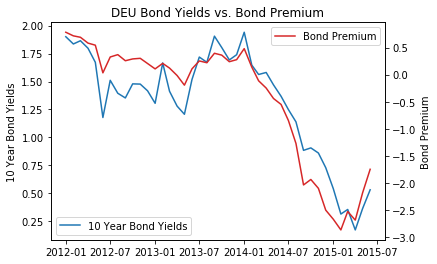

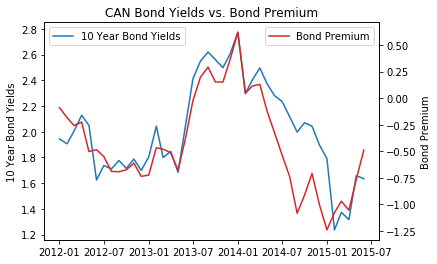

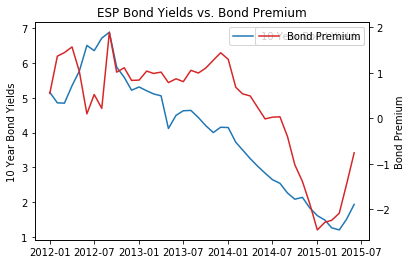

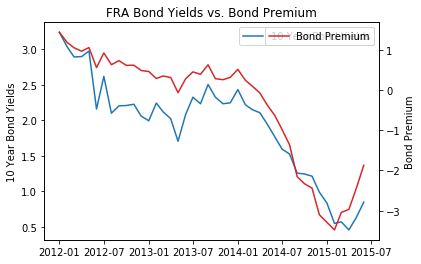

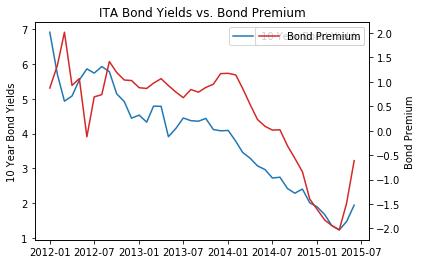

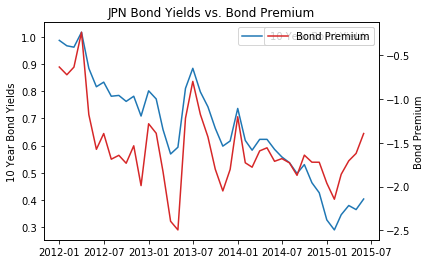

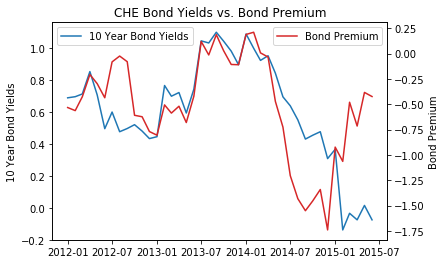

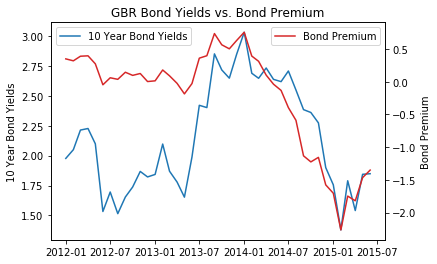

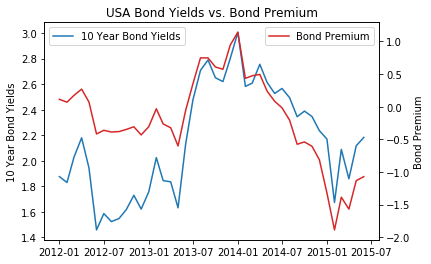

In [371]:
start_date = '2012-01-01'
end_date = '2015-06-01'
bond_premium = LongRates - ShortRates
for country in bond_premium.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Bond Premium'
    ax2.plot(rolling_z_score(bond_premium, 12*7,12*7)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Yields vs. Bond Premium")
    plt.show()

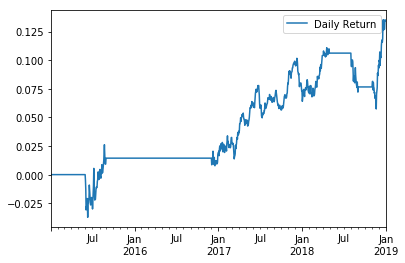

In [368]:
start_date = '1990-01-01'
end_date = '2015-01-01'
trade_date = '2015-01-02'
unwind_date = '2019-01-01'
trade_range = pd.date_range(trade_date, unwind_date, freq='B')
daily_pl = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily P&L"])
prior_weights = pd.Series()
long_returns = BondReturnIdx.pct_change(1)

bond_premium = LongRates - ShortRates
bond_premium = bond_premium.multiply(LongRates.ge(0))
curve_height = (LongRates + ShortRates) * 0.5
max_curve_height = curve_height.max(axis = 1)

daily_ret = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily Return"])
for date in pd.date_range(trade_date, unwind_date, freq='B').date:
    bond_premium_training = bond_premium.loc[start_date:end_date]
    curve_height_training = curve_height.loc[end_date]
    curve_height_training = curve_height_training.multiply(curve_height_training.ge(0))
    one_day_long_return = long_returns.loc[date]
    
    #standardizing data across time 
    normalized_bond_premium = rolling_z_score(bond_premium_training, 12*7,12*7)
    date_normalized_premium = normalized_bond_premium.loc[end_date]
    above_norm = date_normalized_premium.gt(0)
    current_normalized_premium = date_normalized_premium.multiply(above_norm)
    
    #cross-country comparison - weighting by curve height
    curr_max_curve_height = max_curve_height.loc[end_date]
    w_curve_height = curve_height_training.mul(1/curr_max_curve_height, axis = 0)
    long_positions = current_normalized_premium * w_curve_height
    weights_total = long_positions.sum()
    if weights_total != 0:
        #long_positions = long_positions/weights_total
#        daily_ret.loc[date] = long_positions.dot(one_day_long_return) / long_positions.sum()
        min_val = long_positions.min()
        max_val = long_positions.max()
        long_positions = long_positions.apply(lambda x: (x - min_val) / (max_val - min_val))
        daily_ret.loc[date] = long_positions.dot(one_day_long_return) / long_positions.sum()
    else:
        daily_ret.loc[date] = 0

    #calculating return 
    
    #daily_pl.loc[date] = buy_amounts.dot(one_day_long_return)
    end_date = date
    
#     if daily_pl.loc[date].values  < -1:
#         print(long_positions)
#     if above_norm.sum() == 1:
#         sum_1 += 1
#         if long_positions["AUS"] == 1:
#             aus_sum += 1
daily_ret.cumsum().plot()
plt.show()